# Porto Seguro’s Safe Driver Prediction


<br><font color=blue>The aim of this compitation is to predict probability that a driver will intiate an auto insurance claim next year.A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers. </font>


# Import library

In [1]:
#Import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import roc_curve,auc
import xgboost as xgb
import lightgbm as lgb
seed =45
% matplotlib inline

/home/sudhir/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read data set

In [37]:
#path = '../input/'
path = ''
train = pd.read_csv(path+'train.csv',na_values=-1)
test = pd.read_csv(path+'test.csv',na_values=-1)
print('Number rows and columns:',train.shape)
print('Number rows and columns:',test.shape)

Number rows and columns: (595212, 59)
Number rows and columns: (892816, 58)


## Explore data set

In [20]:
train.head(3).T

,0,1,2
id,7.000000,9.000000,13.000000
target,0.000000,0.000000,0.000000
ps_ind_01,2.000000,1.000000,5.000000
ps_ind_02_cat,2.000000,1.000000,4.000000
ps_ind_03,5.000000,7.000000,9.000000
ps_ind_04_cat,1.000000,0.000000,1.000000
ps_ind_05_cat,0.000000,0.000000,0.000000
ps_ind_06_bin,0.000000,0.000000,0.000000
ps_ind_07_bin,1.000000,0.000000,0.000000
ps_ind_08_bin,0.000000,1.000000,1.000000


## Target varaiable

0    573518
1     21694
Name: target, dtype: int64

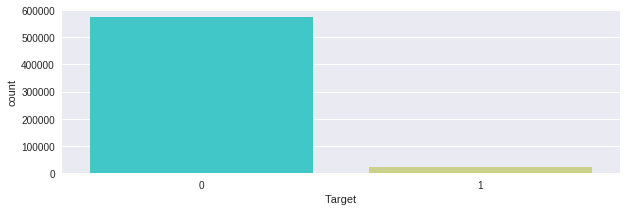

In [4]:
plt.figure(figsize=(10,3))
sns.countplot(train['target'],palette='rainbow')
plt.xlabel('Target')

train['target'].value_counts()

The 'target' variable in imbalanced 

## CORELATION PLOT

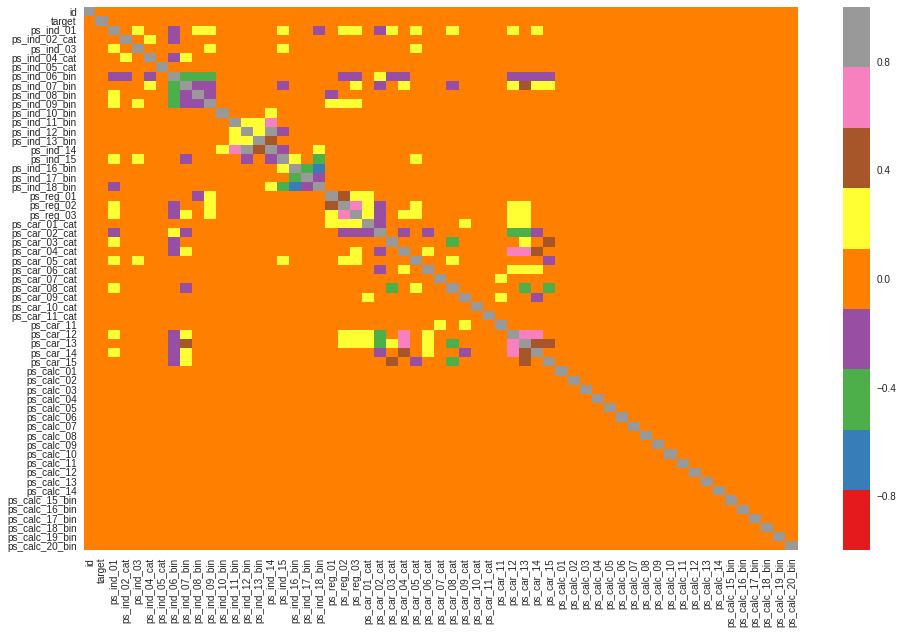

In [9]:
cor = train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor,cmap='Set1');

###  ps calc  *  value as 0 relation with remaining varialble

In [38]:
ps_cal = train.columns[train.columns.str.startswith('ps_calc')] 
train = train.drop(ps_cal,axis =1)
test = test.drop(ps_cal,axis=1)
train.shape

(595212, 39)

In [39]:
train['target'] = train['target'].astype('category')

# Missing value is data set

"""Values of -1 indicate that the feature was missing from the observation. 
The target columns signifies whether or not a claim was filed for that policy holder.""

In [40]:
k= pd.DataFrame()
k['train']= train.isnull().sum()
k['test'] = test.isnull().sum()
k

,train,test
id,0,0.0
target,0,NaN
ps_ind_01,0,0.0
ps_ind_02_cat,216,307.0
ps_ind_03,0,0.0
ps_ind_04_cat,83,145.0
ps_ind_05_cat,5809,8710.0
ps_ind_06_bin,0,0.0
ps_ind_07_bin,0,0.0
ps_ind_08_bin,0,0.0


Missing value in test train data set are in same propotion and same column

In [40]:
def transform_df(df):
    df = pd.DataFrame(df)
    dcol= [c for c in train.columns if train[c].nunique()>2]
    dcol.remove('id')   
    d_median = df[dcol].median(axis=0)
    d_mean = df[dcol].mean(axis=0)
    
    #Add mean and median column to data set having more then 2 categories
    for c in dcol:
        df[c+str('_median_range')] = (df[c].values > d_median[c]).astype(np.int8)
        df[c+str('_mean_range')] = (df[c].values > d_mean[c]).astype(np.int8)            
    return df

In [41]:
train = transform_df(train)
test = transform_df(test)

/home/sudhir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/sudhir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


In [42]:
def missing_value(df):
    col = df.columns
    for i in col:
        if df[i].isnull().sum()>0:
            df[i].fillna(df[i].mode()[0],inplace=True)

In [43]:
missing_value(train)
missing_value(test)

## Reduce memory 

In [44]:
def change_datatype(df):
    float_cols = list(df.select_dtypes(include=['int']).columns)
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

In [45]:
def change_datatype_float(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        df[col] = df[col].astype(np.float32)

In [46]:
change_datatype(train)
change_datatype(test)
change_datatype_float(train)
change_datatype_float(test)

# Univariate analysis

In [24]:
def uniq(df):
    col = df.columns
    for i in col:
        print('\n Unique value of "{}" is "{}" '.format(i,df[i].nunique()))
        #print(df[i].unique())
uniq(train)


 Unique value of "id" is "595212" 

 Unique value of "target" is "2" 

 Unique value of "ps_ind_01" is "8" 

 Unique value of "ps_ind_02_cat" is "4" 

 Unique value of "ps_ind_03" is "12" 

 Unique value of "ps_ind_04_cat" is "2" 

 Unique value of "ps_ind_05_cat" is "7" 

 Unique value of "ps_ind_06_bin" is "2" 

 Unique value of "ps_ind_07_bin" is "2" 

 Unique value of "ps_ind_08_bin" is "2" 

 Unique value of "ps_ind_09_bin" is "2" 

 Unique value of "ps_ind_10_bin" is "2" 

 Unique value of "ps_ind_11_bin" is "2" 

 Unique value of "ps_ind_12_bin" is "2" 

 Unique value of "ps_ind_13_bin" is "2" 

 Unique value of "ps_ind_14" is "5" 

 Unique value of "ps_ind_15" is "14" 

 Unique value of "ps_ind_16_bin" is "2" 

 Unique value of "ps_ind_17_bin" is "2" 

 Unique value of "ps_ind_18_bin" is "2" 

 Unique value of "ps_reg_01" is "10" 

 Unique value of "ps_reg_02" is "19" 

 Unique value of "ps_reg_03" is "5012" 

 Unique value of "ps_car_01_cat" is "12" 

 Unique value of "ps_car

In [25]:
def category_col(df):
    c_col = df.columns
    to_cat_col =[]
    for i in c_col:
        if df[i].nunique()<=104:
            to_cat_col.append(i)
    return to_cat_col


tot_cat_col = category_col(train)

In [26]:
num_col = [c for c in train.columns if c not in tot_cat_col]
#num_col.append('ps_car_15')
#train['ps_car_15'] = train['ps_car_15'].astype('float32')
#test['ps_car_15'] = test['ps_car_15'].astype('float32')
num_col.remove('id')
num_col

['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14']

In [78]:
train.groupby(['ps_ind_05_cat'])['target'].agg(['mean','count',np.std])

DataError: No numeric types to aggregate

In [9]:
#Target encoding

""" Source:
 https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features/notebook"""
def add_noise(series,noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)) )

def target_encoding(train_series=None,test_series=None,target=None,
                   noise_level=0):
    assert len(train_series) == len(target)
    assert test_series.name == train_series.name
    
    temp = pd.concat([train_series,target],axis=1)
    
    # Compute target mean
    aggregated_value = temp.groupby(by=train_series.name)[target.name].agg(['mean','count',np.std])
    total_std = np.std(target)
    aggregated_value['std'].fillna(total_std,inplace=True)
        
    # Compute smoothing
    smoothing_component = aggregated_value['count'] * total_std**2
    smoothing = smoothing_component / (aggregated_value['std']**2 + smoothing_component)
        
    # Apply avearage function to all target data
    mean_total = target.mean()
    mean_value = mean_total * (1 - smoothing) + aggregated_value['mean'] * smoothing
    mean_value_dict = mean_value.rank(axis=0,method='first').to_dict()
    
    train_columns = train_series.replace(mean_value_dict).fillna(mean_total)
    test_columns = train_series.replace(mean_value_dict).fillna(mean_total)
    
    return add_noise(train_columns,noise_level) , add_noise(test_columns , noise_level)


In [10]:
col_cat = train.columns.drop(['id','target','ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14'])
col_cat

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_15'],
      dtype='object')

In [15]:
trn = tst = pd.DataFrame()
for f in col_cat:
    print('target encoding for {}'.format(f))
    trn[f],tst[f] = target_encoding(train_series=train[f],test_series=test[f],target=train['target'],noise_level=0.01)

target encoding for ps_ind_01
target encoding for ps_ind_02_cat
target encoding for ps_ind_03
target encoding for ps_ind_04_cat
target encoding for ps_ind_05_cat
target encoding for ps_ind_06_bin
target encoding for ps_ind_07_bin
target encoding for ps_ind_08_bin
target encoding for ps_ind_09_bin
target encoding for ps_ind_10_bin
target encoding for ps_ind_11_bin
target encoding for ps_ind_12_bin
target encoding for ps_ind_13_bin
target encoding for ps_ind_14
target encoding for ps_ind_15
target encoding for ps_ind_16_bin
target encoding for ps_ind_17_bin
target encoding for ps_ind_18_bin
target encoding for ps_reg_01
target encoding for ps_reg_02
target encoding for ps_car_01_cat
target encoding for ps_car_02_cat
target encoding for ps_car_03_cat
target encoding for ps_car_04_cat
target encoding for ps_car_05_cat
target encoding for ps_car_06_cat
target encoding for ps_car_07_cat
target encoding for ps_car_08_cat
target encoding for ps_car_09_cat
target encoding for ps_car_10_cat
targ

In [55]:
trn.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_15
0,2.958506,2.982569,6.100026,1.974518,1.012402,1.995374,1.993072,0.995345,2.000120,0.996710,...,1.984487,2.018058,3.054268,0.995559,2.001108,1.004422,2.037165,60.244122,3.061485,15.035743
1,1.993731,1.022694,10.094346,0.993311,1.009678,2.000252,1.020487,1.986868,1.975305,1.001679,...,1.993860,0.036593,0.975037,0.999193,1.011363,2.926596,1.965165,4.044569,1.982915,7.971693
2,4.003914,4.023472,3.976882,2.015055,0.998249,2.006134,1.003181,1.999184,2.009761,1.011096,...,2.000301,0.036626,5.006645,0.994391,1.006450,2.959277,1.955954,30.653286,1.009577,12.002434
3,1.003726,0.999817,1.985980,1.007727,1.024720,1.015354,1.001542,0.977880,2.019079,1.005139,...,1.999786,2.000029,1.010799,1.002060,0.997497,2.006441,2.006347,81.264809,1.005972,4.928744
4,1.013188,2.960522,11.893409,1.995720,1.005884,1.005332,0.999391,0.996082,2.001958,0.988597,...,2.023581,0.037037,5.055702,1.007981,1.006275,2.969384,2.006256,9.992725,1.984606,4.937931


In [33]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)


In [35]:
# Target encode ps_car_11_cat
trn, sub = target_encode(train["ps_car_11_cat"], 
                         test["ps_car_11_cat"], 
                         target=train.target, 
                         min_samples_leaf=100,
                         smoothing=10,
                         noise_level=0.01)
trn.head(10)

0    0.038467
1    0.023559
2    0.031581
3    0.044824
4    0.026095
5    0.044061
6    0.023157
7    0.030601
8    0.034795
9    0.045634
Name: ps_car_11_cat_mean, dtype: float64

In [48]:
trn = tst = pd.DataFrame()
for f in col_cat:
    print('target encoding for {}'.format(f))
    trn[f],tst[f] = target_encoding(train_series=train[f],test_series=test[f],target=train['target'],noise_level=0.01)

target encoding for ps_ind_01
target encoding for ps_ind_02_cat
target encoding for ps_ind_03
target encoding for ps_ind_04_cat
target encoding for ps_ind_05_cat
target encoding for ps_ind_06_bin
target encoding for ps_ind_07_bin
target encoding for ps_ind_08_bin
target encoding for ps_ind_09_bin
target encoding for ps_ind_10_bin
target encoding for ps_ind_11_bin
target encoding for ps_ind_12_bin
target encoding for ps_ind_13_bin
target encoding for ps_ind_14
target encoding for ps_ind_15
target encoding for ps_ind_16_bin
target encoding for ps_ind_17_bin
target encoding for ps_ind_18_bin
target encoding for ps_reg_01
target encoding for ps_reg_02
target encoding for ps_car_01_cat
target encoding for ps_car_02_cat
target encoding for ps_car_03_cat
target encoding for ps_car_04_cat
target encoding for ps_car_05_cat
target encoding for ps_car_06_cat
target encoding for ps_car_07_cat
target encoding for ps_car_08_cat
target encoding for ps_car_09_cat
target encoding for ps_car_10_cat
targ

In [37]:
trn.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_15
0,2.963370,2.990649,6.087539,2.005756,1.014977,2.023391,2.009266,0.980764,2.039562,0.996375,...,1.980589,2.010977,3.010604,1.003030,2.022471,0.979819,1.994136,60.233313,2.965324,14.987118
1,2.003909,0.993889,10.220533,0.988327,0.983672,1.976527,1.012078,2.032018,2.005884,1.009299,...,1.986198,0.036457,1.010757,0.992464,0.996307,2.967424,2.053138,4.003076,1.977741,7.964655
2,3.991230,3.969986,4.011545,2.011106,1.002418,2.003770,0.998631,1.961237,2.006027,1.015517,...,1.986216,0.036160,5.045424,0.994539,0.967697,2.979943,1.970844,31.432987,1.009957,11.968598
3,0.996682,1.014764,2.010668,0.989895,1.011497,1.016808,1.011720,0.993186,1.973919,0.998339,...,2.041693,2.026532,0.996658,1.016346,0.990593,2.031046,1.985470,83.135928,0.994360,5.003817
4,1.005976,3.015905,12.014320,2.014921,0.985151,0.997705,1.008958,0.982362,1.988498,0.969965,...,1.987309,0.036041,5.061241,0.974317,1.000833,3.013207,1.984396,9.989116,2.007278,4.895280


In [58]:
X = pd.concat([trn,train[['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14']]],axis=1)
y= train['target']
x_test = pd.concat([tst,test[['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14']]],axis=1)


# Determine outliers in dataset

In [27]:
def outlier(df,columns):
    for i in columns:
        quartile_1,quartile_3 = np.percentile(df[i],[25,75])
        quartile_f,quartile_l = np.percentile(df[i],[1,99])
        IQR = quartile_3-quartile_1
        lower_bound = quartile_1 - (1.5*IQR)
        upper_bound = quartile_3 + (1.5*IQR)
        print(i,lower_bound,upper_bound,quartile_f,quartile_l)
        
        df[i].loc[df[i] < lower_bound] = quartile_f
        df[i].loc[df[i] > upper_bound] = quartile_l
        
num_col = ['ps_reg_03', 'ps_car_13', 'ps_car_14']
outlier(train,num_col)
outlier(test,num_col)

ps_reg_03 0.0848402678967 1.54909583926 0.418330013752 1.85219466686
ps_car_13 0.317880928516 1.25917607546 0.448300511539 1.61761689425


/home/sudhir/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


ps_car_14 0.289156630635 0.460881307721 0.288790583611 0.52345007658
ps_reg_03 0.0815626084805 1.55455860496 0.419076353312 1.85219466686
ps_car_13 0.318886972964 1.25847832114 0.4485283494 1.61723992229
ps_car_14 0.289156630635 0.460881307721 0.288790583611 0.52345007658


# Split data set

In [47]:
X = train.drop(['target','id'],axis=1)
y = train['target'].astype('category')
x_test = test.drop('id',axis=1)

# Hyper parameter tuning

In [16]:
xg_cl = xgb.XGBClassifier(max_depth=4,learning_rate=0.1,n_estimators=5300,objective='binary:logistic',
                          min_child_weight=1,scale_pos_weight=1)
param = {'max_depth':[3,4,5,7,10],
         'learning_rate':[0.01,0.03,0.07,0.1,0.3,0.5],
         'min_child_weight':[1,3,5,7,10],
         'reg_lambda':[0.1,0.5,1,1.3,1.7,2.5],
         'reg_alpha':[1,1.5,3,8,10,12,15],
         'gamma':[0.1,0.5,1,2,5,10],
         'subsample':[0.4,0.5,0.6,0.7,0.8,0.9,1],
        'colsample_bytree':[0.4,0.5,0.6,0.7,0.8,0.9,1],
         'scale_pos_weight':[0.5,1,2,3,5,10]}
clf = GridSearchCV(xg_cl,param,scoring='roc_auc',refit=True,cv=10)

clf.fit(X,y)
print('Best roc_auc: {:.4}, with best params: {}'.format(clf.best_score_, clf.best_params_))


KeyboardInterrupt: 

# Gini metric

In [28]:
def gini(y, pred):
    fpr, tpr, thr = roc_curve(y, pred, pos_label=1)
    g = 2 * auc(fpr, tpr) -1
    return g

def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred)

# XGBoost

In [48]:
def runXGB(xtrain,xvalid,ytrain,yvalid,xtest,eta=0.07,num_rounds=100):
    params = {
        'objective':'binary:logistic',        
        'max_depth':4,
        'learning_rate':eta,
        'eval_metric':'auc',
        'min_child_weight':6,
        'subsample':0.8,
        'colsample_bytree':0.8,
        'seed':seed,
        'reg_lambda':1.3,
        'reg_alpha':8,
        'gamma':10,
        'scale_pos_weight':1.6
        #'n_thread':-1
    }
    
    dtrain = xgb.DMatrix(xtrain,label=ytrain)
    dvalid = xgb.DMatrix(xvalid,label=yvalid)
    dtest = xgb.DMatrix(xtest)
    watchlist = [(dtrain,'train'),(dvalid,'test')]
    
    model = xgb.train(params,dtrain,num_rounds,watchlist,early_stopping_rounds=50,verbose_eval=50)
    pred = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
    pred_test = model.predict(dtest,ntree_limit=model.best_ntree_limit)
    return pred_test,model
    

In [49]:
kf = StratifiedKFold(n_splits=10,random_state=seed,shuffle=True)
pred_test_full =0
cv_score = []
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    
    pred_test,xg_model = runXGB(xtr,xvl,ytr,yvl,x_test,num_rounds=1000,eta=0.1)    
    pred_test_full += pred_test
    cv_score.append(xg_model.best_score)
    i+=1

1 of KFold 10
[0]	train-auc:0.580556	test-auc:0.579459
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.642348	test-auc:0.629826
[100]	train-auc:0.652301	test-auc:0.635193
[150]	train-auc:0.657158	test-auc:0.635812
[200]	train-auc:0.660507	test-auc:0.635988
[250]	train-auc:0.662741	test-auc:0.636616
[300]	train-auc:0.664488	test-auc:0.637125
[350]	train-auc:0.666577	test-auc:0.637671
[400]	train-auc:0.6676	test-auc:0.637783
[450]	train-auc:0.668935	test-auc:0.638062
Stopping. Best iteration:
[420]	train-auc:0.668102	test-auc:0.63812

2 of KFold 10
[0]	train-auc:0.585669	test-auc:0.591409
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.641702	test-auc:0.634419
[100]	train-auc:0.652559	test-auc:0.64013
[150]	train-auc:0.657277	test-auc:0.641126
[200]	train-auc:0.660553	tes

# Model accuracy

In [50]:
print(cv_score)
print('Mean cv_score',np.mean(cv_score))

[0.63812, 0.642914, 0.634067, 0.648481, 0.64085, 0.651487, 0.632934, 0.648978, 0.648358, 0.642005]
Mean cv_score 0.6428194


In [51]:
pred_xgb = pred_test_full/10
pred_xgb[:5]

array([ 0.04224966,  0.04249311,  0.03926532,  0.02290242,  0.05320399], dtype=float32)

# Important Features

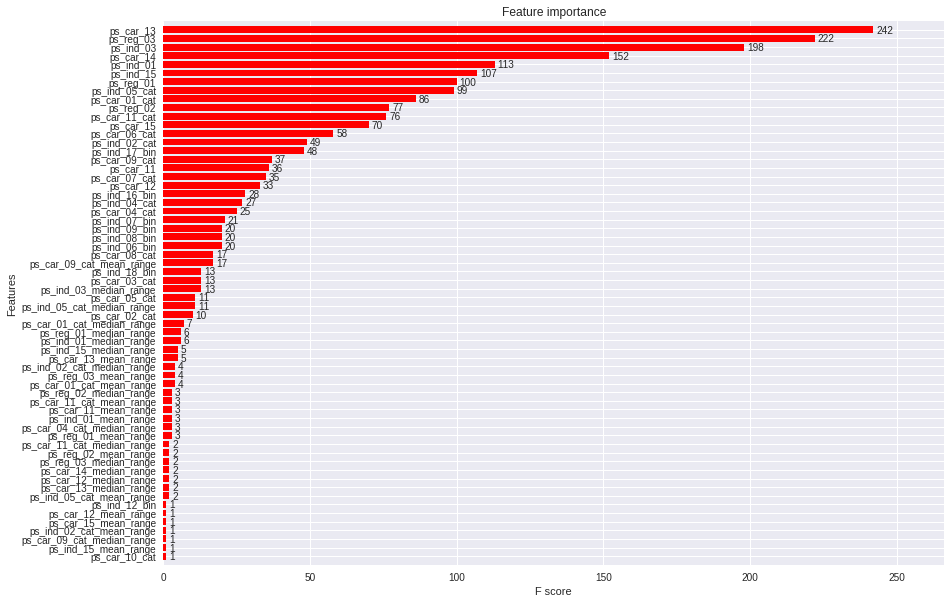

In [52]:
fig,ax = plt.subplots(figsize=(14,10))
xgb.plot_importance(xg_model,ax=ax,height=0.8,color='r')
#plt.tight_layout()
plt.show()

# Predict for unsen data set

In [53]:
y_pred = pred_xgb
submit = pd.DataFrame({'id':test['id'],'target':y_pred})
#submit.to_csv('xgb_porto.csv',index=False)
submit.to_csv('xgb_porto.csv.gz',index=False,compression='gzip') 

# Light GBM

In [26]:
def runLGB(train,valid,y_train,y_valid,test,eta=0.5,num_rounds=10,early_stop=50,max_depth=10):
    
    param = {
            'objective':'binary',
            'boosting':'gbdt',
            'learning_rate':eta,            
            'metric':'auc',
            'bagging_fraction':0.8,
            #'bagging_freq':5,
            'bagging_seed':seed,
            'num_leaves':100,
            'feature_fraction':0.8,
            #'verbose':10,            
            'min_child_weight':10,
            'max_depth':max_depth,
            'reg_alpha':1.5, 
            'reg_lambda':5,
            'scale_pos_weight':5       
            #'nthread':-1           
            }
   
    lgtrain = lgb.Dataset(train,label=y_train)
    lgvalid = lgb.Dataset(valid,label=y_valid)
    
    model=lgb.train(param,lgtrain,num_rounds,valid_sets=lgvalid,
              early_stopping_rounds=early_stop,verbose_eval=50 )
    #lg_pred = model.predict(xvl,num_iteration=model.best_iteration)
    pred = model.predict(test,num_iteration=model.best_iteration)    
    return pred,model

In [27]:
#Kfold
kf = StratifiedKFold(n_splits =5,random_state=seed,shuffle=True)
pred_test_full=0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index], X.loc[test_index]    
    ytr,yvl = y[train_index], y[test_index]
    
    pred_test,lg_model = runLGB(xtr,xvl,ytr,yvl,x_test,eta=0.1,num_rounds=1000,max_depth=7)
    pred_test_full +=pred_test
    cv_score.append(lg_model.best_score)
    i+=1

1 of KFold 5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.637261
[100]	valid_0's auc: 0.635718
Early stopping, best iteration is:
[65]	valid_0's auc: 0.637864
2 of KFold 5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.637016
[100]	valid_0's auc: 0.636998
Early stopping, best iteration is:
[83]	valid_0's auc: 0.637397
3 of KFold 5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.644203
Early stopping, best iteration is:
[47]	valid_0's auc: 0.644413
4 of KFold 5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.634972
[100]	valid_0's auc: 0.634182
Early stopping, best iteration is:
[74]	valid_0's auc: 0.635912
5 of KFold 5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.641022
[100]	valid_0's auc: 0.638666
Early stopping, best iteration is:
[51]	valid_0's auc: 0.641395


In [28]:
pred_lgb = pred_test_full/5

# Important Features

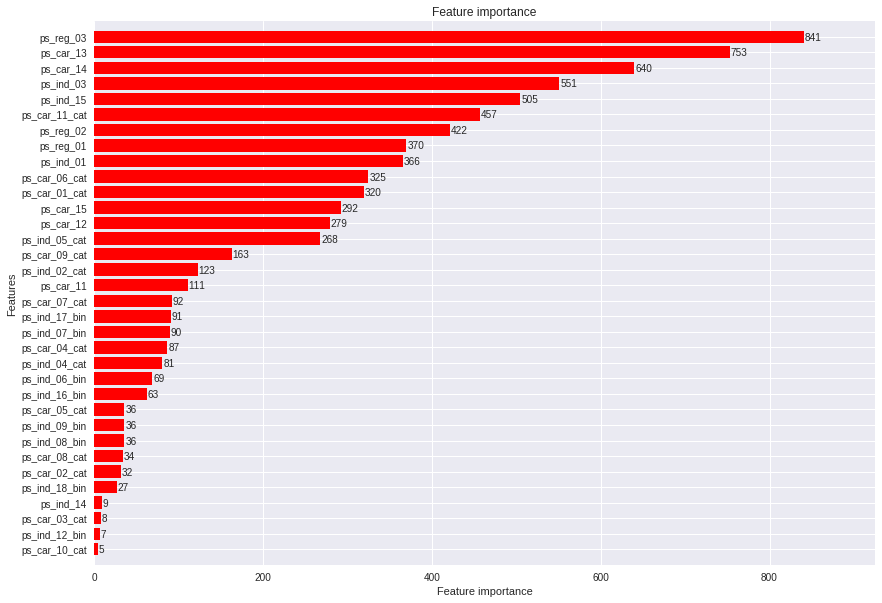

In [28]:
fig,ax = plt.subplots(figsize=(14,10))
lgb.plot_importance(lg_model,ax=ax,height=0.8,color='r')
#plt.tight_layout()
plt.show()

In [31]:
y_pred = pred_lgb*0.7+pred_xgb*0.3
submit = pd.DataFrame({'id':test['id'],'target':y_pred})
#submit.to_csv('xglg_porto.csv',index=False)
submit.to_csv('lr_porto.csv.gz',index=False,compression='gzip') 

# Thank you for visiting